# Logistic Regression
## Aspect sentiment anlysis (Vietnamese)
### Group 4
--- 
### Author

## import requirement library

In [3]:
from underthesea import sent_tokenize
import pandas as pd
from pyvi import ViTokenizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%matplotlib inline      

## Data-transformer class

this class allows us work with specific dataset in this case. You can read some data file in same repo to understand it's structure

---
### Descibe data
in each record 
* first line is number of record, it's start by # follow a number.
* second line is text.
* third line is aspect sentiment analyst has structure like {ENTITY#ATTRIBUTE, SENTIMENT} 

In [4]:
class Data_transformer:
    def __init__(self) -> None:
        self.__tokenizer = ViTokenizer
        pass
    def __removepunc(self, text):
        
        return re.sub(r'[^\w\s]','',text)
    def __tokenize(self, text):
        return self.__tokenizer.tokenize(text)
    def text_preprocessing(self, text):
        """_summary_
            Preprocessing function, this function include three step:
            * tokenize text (for Vietnamese),
            * remove punctuation,
            * lower_case text.
            * return result
        
        Args:
            text (string): raw test

        Returns:
            string: text's preprocessed
        """
        text_token = self.__tokenize(text)
        text_remove_punc = self.__removepunc(text_token)
        return text_remove_punc.lower()
    def read_text_only(self, filename):
        """_summary_
            This function will read only text in raw .txt file
       
        Args:
            filename (string): path to data file

        Returns:
            list: list of raw text
        """
        texts = []
        with open(filename, 'r', encoding='utf-8') as f:
            lines = filter(None, (line.rstrip() for line in f))
            for line in lines:
                line = line.strip()
                if line.startswith('#'):
                    pass
                elif line.startswith('{') and line.endswith('}'):
                    pass
                else:
                    texts.append(line)
        return texts
    def load_data(self, filename):
        """_summary_
            This function return data represent in 2d list.
            it has exactly 4 column incude: text, sentiment, entity and attribute. 
            *Remember each text will be seperated into many sentences.
        
        Args:
            filename (string): path to data

        Returns:
            list: 2d list for all record
        """
        data = []
        with open(filename, 'r', encoding='utf-8') as f:
            index = 0
            texts = []
            for line in f:
                line = line.strip()
                if line.startswith('#'):
                    index = int(line[1:])
                    pass
                elif line.startswith('{') and line.endswith('}'):
                    aspects = re.findall(r'{(.+?),\s*(.+?)}', line)
                    min_len = len(aspects) if len(aspects)<len(texts) else len(texts) 
                    for i in range(min_len):
                        aspect, sentiment = aspects[i]
                        text = texts[i]
                        s_attribute = aspect.split('#')
                        data_line = [self.text_preprocessing(text), sentiment, s_attribute[0], s_attribute[1]]
                        data.append(data_line) 
                else:
                    texts = sent_tokenize(line)
        return data
    def load_to_df(self, filename, columns = ['text', 'label', 'entity', 'attribute']):
        """_summary_
        
            This function return pandas dataframe.
            it has exactly 4 column incude: text, sentiment, entity and attribute. 
            *Remember each text will be seperated into many sentences.
        
        Args:
            filename (string): path to data
            columns (list): list of column's name.
        Returns:
            list: pandas dataframe
        """
        data = self.load_data(filename)
        df = pd.DataFrame(data=data, columns=columns)
        return df
    def text2feature(self, text):
        """_summary_
            This function will break a normal text into list of sentences and preprocess each sentences
        
        Args:
            text (string): raw text

        Returns:
            list: list of sentences's preprocessed
        """
        list_f = []
        list_text = sent_tokenize(text)
        for text in list_text:
            list_f.append(self.text_preprocessing(text))
        return list_f

## Logistic Regression model
This class is multinomial Logistic regression model (aspect-sentiment_analyst approach) use bag of word as features 

**Note** that this class work for this data inclute 3 layer ENTITY, ATRIBUTE and SENTIMENT

In [137]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
class Aspect_logreg_model:
    def __init__(self) -> None:
        self.data_trans = Data_transformer()
        self.pineline = Pipeline([
            ('cv', CountVectorizer()),
            ('tf', TfidfTransformer()),
            ('nb', LogisticRegression())
        ])
        pass
    def reversed_normal_scale(self, lis):
        arr = 1 - lis/np.sum(lis)
        return arr/np.sum(arr)
    def fit3layer(self, df:pd.DataFrame, x_index = 0, y_indexes = [1,2,3]):
        """_summary_
            ***IMPORTANT***
            This is a main fit function to work for aspect sentiment analysis, it will fit for all 3-layer.
            Wanna predict, evaluate each aspect? Pls call .pipeline_<element>.<attribute> you want to work. 
            Note that you have to call this function before you want to use these attribute.
            <element> include [sen, entity, attribute]
        
        Args:
            df: pandas.DataFrame: a dataframe to fit for this model, you dont need to seperate into features and label, just pass dataframe, it auto do it for you.
            ***IMPORTANT***
            Dataframe must be a result of Data_transformer class
            x_index: int: index of text (must integer, no matter what index you use for dataframe, pass position of text series), we will create feature for you . 
            y_indexes: list<int>: List of classs index (must integer, no matter what index you use for dataframe, pass position of text series)
        """
        self.list_of_name = df.columns
        self.x_index = x_index
        self.y_index = y_indexes
        X = df[self.list_of_name[x_index]]
        self.models = []

        for label_index in y_indexes:
             self.models.append(
                  Pipeline([
                        ('cv', CountVectorizer()),
                        ('tf', TfidfTransformer()),
                        ('sd', StandardScaler(with_mean=False)),
                       # ('mas', MaxAbsScaler()),
                        ('logreg', LogisticRegression(verbose=2, penalty='l2', solver='sag'))
                ])
             )
        for k in range(len(y_indexes)):
             self.models[k].fit(X, df[self.list_of_name[y_indexes[k]]])
        pass 
    def fit_mono(self, X_, y_)->None:
        """_summary_
            Fit for specific class you want, if you want use this model simply call .pipeline.<attribute you want>
        
        Args:
            X_ (_type_): _description_
            y_ (_type_): _description_
        """
        X = X_
        y = y_ 
        self.pineline.fit(X, y)
        pass
    def evaluate(self, df)->None:
        """_summary_
        This will evalute 3 layer inclute sentiment, entity and attribute
        
        Args:
            dataframe: test dataframe
        """
        X = df[self.list_of_name[self.x_index]]
        for k in range(len(self.y_index)):
             y_pred = self.models[k].predict(X)
             y_true = df[self.list_of_name[self.y_index[k]]]
             print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=1))
    def specific_class_report(self, X, y, model):
            y_pred = model.predict(X)
            print(classification_report(y, y_pred))
    def detail_predict(self, text):
        """_summary_
            This function will predict aspect sentiment for a text, include entity, attribute and sentimet. 
            Structure of predict will be like this {ENTITY#ATTRIBUTE, SENTIMENT}
        
        Args:
            text (string): text you want predict

        Returns:
            aspect-sentiment anlyst: list of sentiment-analys have structure like i describe above
        """
        aspect_l = []
        texts = self.data_trans.text2feature(text)
        for text in texts:
            entity = self.models[1].predict([text])
            attr = self.models[2].predict([text])
            sen = self.models[0].predict([text])
            aspect_l.append(f'{{{entity[0]}#{attr[0]}, {sen[0]}}}')
        return aspect_l

## Hotel dataset 
Work with hotel dataset

In [ ]:
data_trans = Data_transformer()
df = data_trans.load_to_df('data_hotel_train.txt')
df.head(5)

In [136]:
df['attribute'].value_counts().to_list()

[3243, 1873, 1140, 876, 826, 421, 272, 71]

### Data exploration

In [ ]:
sns.countplot(df,x='label')
plt.title("Count sentiment in hotel dataset")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(df,x='entity')
plt.title("Count entitys in hotel dataset")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(df,x='attribute')
plt.title("Count attribute in hotel dataset")
plt.show()

We find that there are  unblanced label on all sentiment, attribute and entity

### Fit model

In [138]:
model = Aspect_logreg_model()
model.fit3layer(df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: sample_weight.shape == (3,), expected (8722,)!

Try to aspect sentiment analyst in specific text

In [83]:
model.detail_predict("Gi√° c·∫£ kh√° m·ªÅm, h·ª£p v·ªõi t√∫i ti·ªÅn. Ph√≤ng s·∫°ch, g·ªçn g√†ng. T√¥i kh√° h√†i l√≤ng v·ªõi Kh√°ch s·∫°n n√†y trong k·ª≥ ngh·ªâ v·ª´a r·ªìi. R·∫•t c·∫£m ∆°n Mytour ƒë√£ h·ªó tr·ª£.")

['{HOTEL#PRICES, positive}',
 '{ROOMS#CLEANLINESS, positive}',
 '{HOTEL#COMFORT, positive}',
 '{HOTEL#GENERAL, positive}']

Seem it works well with positive comment

In [84]:
model.detail_predict("Nh√¢n vi√™n l·ªãch s·ª±, ph·ª•c v·ª• chu ƒë√°o. Kh√°ch s·∫°n ·ªü s·∫°ch s·∫Ω. B√£i bi·ªÉn kh√¥ng ƒë∆∞·ª£c s·∫°ch s·∫Ω l·∫Øm, c√≥ nhi·ªÅu r√°c, n∆∞·ªõc ƒë·ª•c")

['{SERVICE#GENERAL, positive}',
 '{HOTEL#CLEANLINESS, positive}',
 '{FACILITIES#CLEANLINESS, negative}']

It still work with a review has negative sentiment.

### Evalute 

on train dataset

In [85]:
model.evaluate(df)

              precision    recall  f1-score   support

    negative       0.92      0.82      0.86      1679
     neutral       0.93      0.62      0.74       373
    positive       0.94      0.98      0.96      6670

    accuracy                           0.94      8722
   macro avg       0.93      0.81      0.86      8722
weighted avg       0.94      0.94      0.93      8722

                precision    recall  f1-score   support

    FACILITIES       0.83      0.71      0.76       797
   FOOD&DRINKS       0.80      0.70      0.74       688
         HOTEL       0.75      0.89      0.81      2857
      LOCATION       0.83      0.78      0.80       865
         ROOMS       0.77      0.76      0.76      1757
ROOM_AMENITIES       0.88      0.64      0.74       580
       SERVICE       0.73      0.69      0.71      1178

      accuracy                           0.78      8722
     macro avg       0.80      0.74      0.76      8722
  weighted avg       0.78      0.78      0.77      8722



In sentiment it has F1-score accuracy pretty good, but just in positive, and very bad on neutral, because our data set very unbalanced,
With entity and attribute all have bad performence, maybe our data unbalanced and there are many class, but dataset dont large enough. the result will be easily skewed towards the dominant class 

In [86]:
df_test = data_trans.load_to_df('data_hotel_test.txt')
df_test.head(5)

text     label  \
0  ga gi∆∞·ªùng kh√¥ng s·∫°ch  nh√¢n_vi√™n qu√™n d·ªçn ph√≤ng...  negative   
1  nv nhi·ªát_t√¨nh  ph√≤ng ·ªü s·∫°ch_s·∫Ω  ti·ªán_nghi  v·ªã_...  positive   
2  ƒëi b·ªô ra bi·ªÉn g·∫ßn  ti·ªán ƒëi_l·∫°i ph√≤ng view bi·ªÉn...  positive   
3  t·∫•t_c·∫£ m·ªçi th·ª© ƒë·ªÅu s·∫°ch_s·∫Ω  gi∆∞·ªùng ng·ªß r·∫•t tho...  positive   
4  kh√¥ng c√≥ qu·∫°t_ƒëi·ªán m√† ch·ªâ c√≥_ƒëi·ªÅu h√≤a n√™n c√≥ c...  positive   

           entity    attribute  
0  ROOM_AMENITIES  CLEANLINESS  
1         SERVICE      GENERAL  
2        LOCATION      GENERAL  
3           HOTEL  CLEANLINESS  
4  ROOM_AMENITIES      COMFORT

In [87]:
model.evaluate(df_test)

              precision    recall  f1-score   support

    negative       0.38      0.45      0.41       231
     neutral       0.03      0.01      0.02        84
    positive       0.84      0.84      0.84      1154

    accuracy                           0.73      1469
   macro avg       0.42      0.44      0.42      1469
weighted avg       0.72      0.73      0.73      1469

                precision    recall  f1-score   support

    FACILITIES       0.12      0.19      0.15        68
   FOOD&DRINKS       0.32      0.26      0.28       143
         HOTEL       0.32      0.43      0.36       290
      LOCATION       0.38      0.31      0.35       153
         ROOMS       0.35      0.42      0.38       356
ROOM_AMENITIES       0.34      0.19      0.24       183
       SERVICE       0.40      0.29      0.33       276

      accuracy                           0.33      1469
     macro avg       0.32      0.30      0.30      1469
  weighted avg       0.34      0.33      0.33      1469



In test dataset it's little lower perfomance in three class.

Test with 10 review from test data

In [34]:
textlist = data_trans.read_text_only('data_hotel_test.txt')
for i in range(10, 20):
    print(f'#{i+1}')
    text = textlist[i]
    print(text)
    print(str(model.detail_predict(text)))
    

#11
kh√°ch s·∫°n nh·ªè nh∆∞ng r·∫•t ƒë·∫πp v√† sang tr·ªçng , nh√¢n vi√™n vui v·∫ª nhi·ªát t√¨nh , gi√° c·∫£ h·ª£p l√Ω cho m·ªôt kh√°ch s·∫°n g·∫ßn bi·ªÉn .
['{HOTEL#DESIGN&FEATURES, positive}']
#12
Kh√¥ng gi·ªëng nh∆∞ qu·∫£ng c√°o v√† ƒë√°nh gi√° tr√™n booking. ƒê·∫∑t ph√≤ng suite nh∆∞ng v√¨ h·∫øt n√™n cho l√™n ph√≤ng cao nh·∫•t n·∫±m ph√≠a sau, k c√≥ c·ª≠a k√≠nh ban c√¥ng nh∆∞ ƒë√£ Book tr∆∞·ªõc ƒë√≥. Ch√∫ng t√¥i ƒë∆∞·ª£c y√™u c·∫ßu kh√¥ng ƒë·ªông v√†o gi∆∞·ªùng b√™n c·∫°nh v√¨ gi√° ƒë·∫∑t l√† ph√≤ng 1 gi∆∞·ªùng. Ok kh√¥ng sao nh∆∞ng ph√≤ng qu√° nhi·ªÅu mu·ªói. M√¨nh mang theo b√© 3 th√°ng ph·∫£i tr·∫£ ph√≤ng trong ƒë√™m v√¨ mu·ªói qu√° nhi·ªÅu kh√¥ng th·ªÉ ng·ªß ƒë∆∞·ª£c. Toilet b·∫©n, b√†n tr√† b·∫©n, lau kh√¥ng s·∫°ch, c√≤n r·∫•t nhi·ªÅu v·∫øt tr√† v√† c√† ph√™ c≈©. N·ªÅn g·∫°ch r√≠t do kh√¥ng lau. Kh√¥ng c√≥ ly u·ªëng n∆∞·ªõc, m·∫∑c d√π ƒëi thang m√°y xu·ªëng nhi·ªÅu l·∫ßn nh∆∞ng ks b·∫£o kh√¥ng c√≥ ly. Trong khi l·∫°i ƒë·ªÉ tr√† v√† c√† ph√™ tr√™n b√†n. Theo ƒë√°nh gi√° khen tr√

## Restaurant

In [56]:
df_res = data_trans.load_to_df('data_Restaurant_train.txt')
df_res.head(5)

text     label    entity  \
0  _ ·∫£nh ch·ª•p t·ª´ h√¥m_qua  ƒëi ch∆°i v·ªõi gia_ƒë√¨nh v√†...   neutral      FOOD   
1  _ h√¥m_qua ƒëi ƒÉn tr∆∞a mu·ªôn  ai c≈©ng ƒë√≥i h·∫øt n√™n...   neutral      FOOD   
2  _h∆∞∆°ng v·ªã th∆°m ngon  ƒÉn cay cay r·∫•t th√≠ch  n√™m...  positive      FOOD   
3  ngo√†i_ra menu qu√°n c≈©ng nhi·ªÅu m√≥n kh√°c nhau th...  positive      FOOD   
4  kh√°ch c·ªßa qu√°n ƒë√¥ng n√™n nhi·ªÅu khi nh√¢n_vi√™n ph...  positive  AMBIENCE   

       attribute  
0  STYLE&OPTIONS  
1        QUALITY  
2        QUALITY  
3  STYLE&OPTIONS  
4        GENERAL

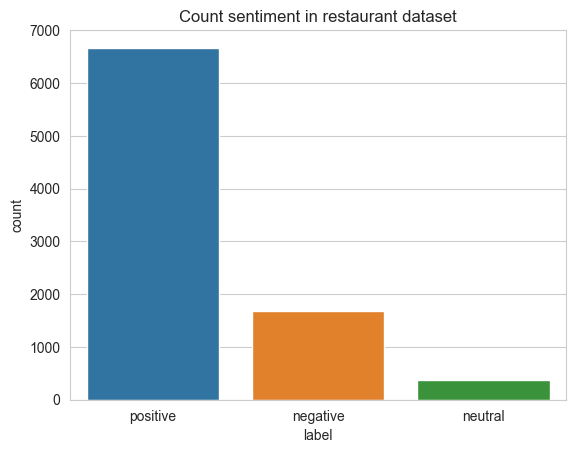

In [18]:
sns.countplot(df,x='label')
plt.title("Count sentiment in restaurant dataset")
plt.show()

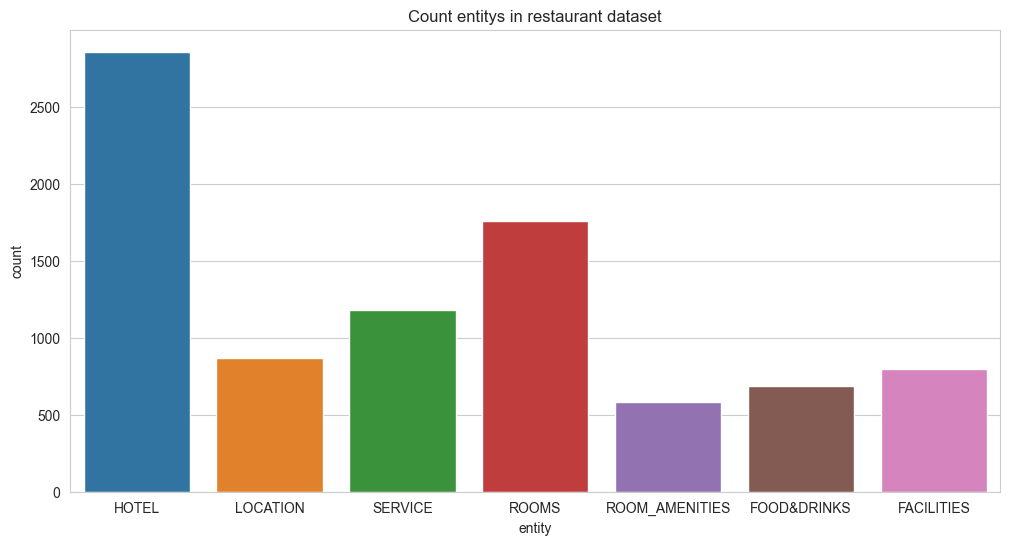

In [19]:
plt.figure(figsize=(12,6))
sns.countplot(df,x='entity')
plt.title("Count entitys in restaurant dataset")
plt.show()

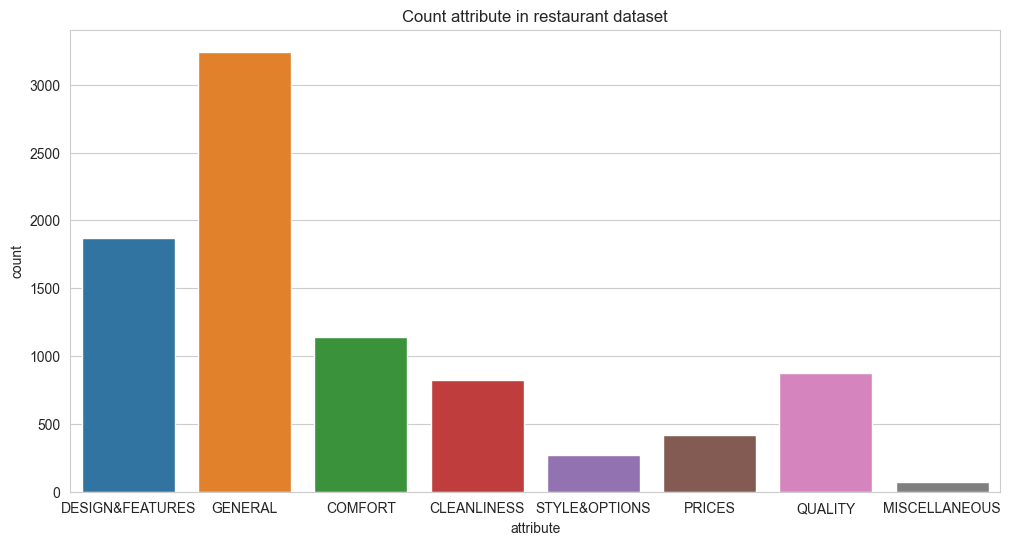

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(df,x='attribute')
plt.title("Count attribute in restaurant dataset")
plt.show()

In [57]:
model_res = Aspect_logreg_model()
model_res.fit3layer(df_res)

C:\Users\drawt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\drawt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Test with specific text

In [22]:
print(model_res.detail_predict('ch·ªï n√†y g·∫ßn nh√† m√¨nh n√™n gh√© th·ª≠, qu√°n tho√°ng m√°t, nh√¢n vi√™n ph·ª•c v·ª• chu ƒë√°o, m√≥n ƒÉn v·ª´a t√∫i sinh vi√™n! c√≥ m·∫•y m√≥n l·∫° n·ªØa k·∫øt nh·∫•t l√† c√°i c√°nh v·ªãt ƒë√≥'))

['{AMBIENCE#GENERAL, neutral}', '{RESTAURANT#QUALITY, neutral}']


In [58]:
model_res.evaluate(df_res)

              precision    recall  f1-score   support

    negative       0.96      0.44      0.60       456
     neutral       0.91      0.54      0.68      1169
    positive       0.87      0.99      0.93      5362

    accuracy                           0.88      6987
   macro avg       0.91      0.66      0.74      6987
weighted avg       0.89      0.88      0.87      6987

              precision    recall  f1-score   support

    AMBIENCE       0.87      0.52      0.65       535
      DRINKS       0.89      0.36      0.51       185
        FOOD       0.82      0.99      0.89      4676
    LOCATION       0.94      0.62      0.75       274
  RESTAURANT       0.89      0.56      0.68       840
     SERVICE       0.85      0.41      0.56       477

    accuracy                           0.83      6987
   macro avg       0.88      0.58      0.67      6987
weighted avg       0.84      0.83      0.81      6987

               precision    recall  f1-score   support

      GENERAL       

In [24]:
df_rest_test = data_trans.load_to_df('data_Restaurant_test.txt')

In [59]:
model_res.evaluate(df_rest_test)

              precision    recall  f1-score   support

    negative       0.21      0.04      0.07       125
     neutral       0.34      0.09      0.14       477
    positive       0.71      0.95      0.81      1386

    accuracy                           0.68      1988
   macro avg       0.42      0.36      0.34      1988
weighted avg       0.59      0.68      0.60      1988

              precision    recall  f1-score   support

    AMBIENCE       0.29      0.12      0.17       224
      DRINKS       0.29      0.03      0.05       144
        FOOD       0.53      0.87      0.66       981
    LOCATION       0.58      0.22      0.32       166
  RESTAURANT       0.28      0.13      0.18       340
     SERVICE       0.23      0.08      0.11       133

    accuracy                           0.49      1988
   macro avg       0.37      0.24      0.25      1988
weighted avg       0.43      0.49      0.41      1988

               precision    recall  f1-score   support

      GENERAL       

We meet the same issue with hotel dataset.
I think solution for this case √≠s make dataset more balanced, but don't scale down our dataset, we need more time to work with dataset.

Test with 10 review from test data

In [26]:
textlist = data_trans.read_text_only('data_Restaurant_test.txt')
for i in range(50,60):
    print(f'#{i+1}')
    text = textlist[i]
    print(text)
    print(str(model_res.detail_predict(text)))

#51
Th√®m b√°nh canh gh√™ m√† ng√†y n√†o c≈©ng c√≥ t√¥ b√°nh canh h·∫π n√†y ƒÉn l√† dzui ƒë·ªùi g√≤i. T√¥ b√°nh canh h·∫π 40k m√† v√¥ v√†n ch·∫£ c√° (m·∫∑c d√π h∆°i kh√¥), tr·ª©ng c√∫t v√† 1 ƒë·ªëng h·∫π. N∆∞·ªõc l√®o th∆°m m√πi ch·∫£ c√° v√† thanh, ko tanh. Dƒ©a b√°nh b√®o 32k ƒë∆∞·ª£c 12 c√°i nh·ªè m√† b·ªôt d√†y qu√°, l·∫°i kh√¥ n·ªØa, ko ƒë√°ng ti·ªÅn. C√≥ ƒëi·ªÅu th√≠ch m·∫•y mi·∫øng b√°nh m√¨ chi√™n tr√™n m·∫∑t, ƒÉn gi√≤n r·ª•m. N∆∞·ªõc m·∫Øm pha ngon, v·ª´a mi·ªáng. Dƒ©a b√°nh b·ªôt l·ªçc 6 c√°i 36k ƒÉn ƒë∆∞·ª£c h∆°n b√°nh b√®o nh∆∞ng n·∫øu b·ªôt m·ªÅm h∆°n t√≠ n·ªØa th√¨ ngon h∆°n. Th√≠ch nh·∫•t l√† ·ªü ƒë√¢y d√πng m·ª° h·∫π, ko ph·∫£i m·ª° h√†nh n√™n m√≥n n√†o c≈©ng th∆°m ph·ª©c m√πi h·∫π. N√≥i chung l√† qu·∫£n b√° ƒë·∫∑c s·∫£n x·ª© N·∫´u th√†nh c√¥ng nh√≥e üëçüëÑ
['{FOOD#QUALITY, positive}', '{FOOD#QUALITY, positive}', '{FOOD#QUALITY, positive}', '{FOOD#PRICES, positive}', '{RESTAURANT#GENERAL, positive}', '{FOOD#PRICES, positive}', '{SERVICE#GENERAL, positive}', '{FOOD#QUA

# Conclusion
Our special logistic regression model solved aspect base sentiment analysis problem, althought performance not good, but there are many way to improve it in future.

---

# Thank for you reading.